## 0. Preamble

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import functools
import json
from collections import defaultdict
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from generation.graph import SATGraph
from history import History
from IPython.display import display


sns.set()


In [86]:
def savefig(name: str, **kwargs):
    kwargs.setdefault("dpi", 200)
    kwargs.setdefault("bbox_inches", "tight")
    kwargs.setdefault("transparent", True)
    plt.savefig(name, **kwargs)


def load_history(
    directory: str,
    limit_episodes: int | None = None,
    keep_full_step: bool = False,
    base: str = "../lamgate/runs/SAGE",
) -> History:
    h = History.load(base + "/" + directory, keep_full_steps=keep_full_step)

    if limit_episodes is not None:
        h.last_step = h.last_step[h.last_step.index < limit_episodes]
        h.episode = h.episode[h.episode.index < limit_episodes]

    print("Loaded history from", directory.split("/")[-1])
    return h


def get_group(df: pd.DataFrame, group_name: str):
    prefix = group_name + "/"
    cols = [col for col in df.columns if col.startswith(prefix)]
    return df[cols].rename(columns=lambda name: name.removeprefix(prefix), copy=False)


def plot_metrics(
    hs: dict[str, History],
    metric: str = "time_cpu",
    legend_title="Experiment",
    window_size: int = 200,
    use_median: bool | None = None,
    last_episodes: int = 200,
    saveto: str | None = None,
    title: str | None = None,
    move_legend: bool = False,
    new_figure: bool = True,
):
    if use_median is None:
        use_median = metric == "time_cpu"

    metrics = []
    metrics_end = []
    for name, h in hs.items():
        agg_fn = "median" if use_median else "mean"
        m = (
            get_group(h.last_step, "metrics")
            .rolling(window_size)
            .agg(agg_fn)
            .reset_index()
        )
        m[legend_title] = name
        metrics.append(m)
        metrics_end.append(m.iloc[-last_episodes:])
    metrics = pd.concat(metrics, ignore_index=True)
    metrics_end = pd.concat(metrics_end, ignore_index=True)

    if new_figure:
        plt.figure()
    sns.lineplot(x="episode", y=metric, hue=legend_title, data=metrics)
    metric_str = "CPU Time" if metric == "time_cpu" else metric.title()
    mode_str = "median" if use_median else "avg."
    plt.ylabel(f"Moving {mode_str} of {metric_str} (window size={window_size})")
    plt.xlabel("Episode")
    if title:
        plt.title(title)
    plt.tight_layout()
    if move_legend:
        sns.move_legend(plt.gca(), loc="upper left", bbox_to_anchor=(1, 1))
    if saveto:
        savefig(saveto + "-lineplot.png")


## 1. Initial experiments

In [75]:
s1_base = load_history("s1 (base run)", limit_episodes=1500)
s1_uniform = load_history("s1 (test_uniform_sampling)", limit_episodes=1500)

s1_comp = load_history("s1 (comp_obs)", limit_episodes=1500)
s1_int = load_history("s1 (int_rewards)", limit_episodes=1500)
s1_overlaps = load_history("s1 (overlaps)", limit_episodes=1500)
s1_int_overlaps = load_history("s1 (int_rewards)", limit_episodes=1500)
s1_overlaps_decisions = load_history(
    "s1 (overlaps, metric=decisions)", limit_episodes=1500
)
s1_int_overlaps_decisions = load_history(
    "s1 (overlaps, int_rewards, metric=decisions)", limit_episodes=1500
)


Loaded history from s1 (base run)
Loaded history from s1 (test_uniform_sampling)
Loaded history from s1 (comp_obs)
Loaded history from s1 (int_rewards)
Loaded history from s1 (overlaps)
Loaded history from s1 (int_rewards)
Loaded history from s1 (overlaps, metric=decisions)
Loaded history from s1 (overlaps, int_rewards, metric=decisions)


### 1.1 G2SAT Sampling Performance

In [76]:
def get_perf(h: History):
    return get_group(h.episode, "timing").sum() / h.episode["num_steps"].sum()


perf = pd.DataFrame(
    [
        get_perf(s1_base),
        get_perf(s1_uniform),
    ]
)
perf["sampling_method"] = ["g2sat", "uniform"]
perf["step"] -= perf["sample_pairs"]

perf


logger   predict  sample_pairs      step sampling_method
0  0.000415  0.003479      0.000422  0.000229           g2sat
1  0.000454  0.005631      0.015403  0.000269         uniform

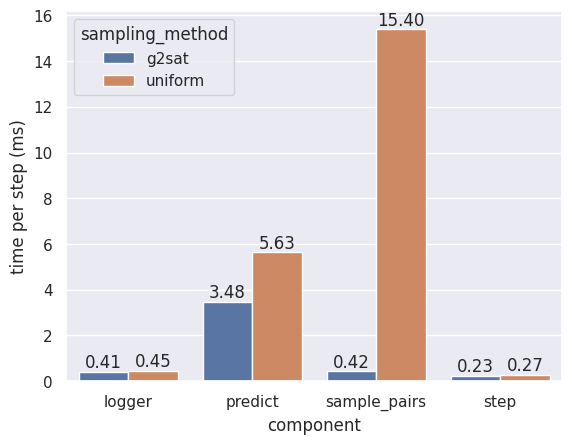

In [77]:
perf_molten = perf.melt(
    id_vars=["sampling_method"],
    var_name="component",
    value_name="timing",
)
perf_molten["timing"] *= 1e3

ax = sns.barplot(x="component", y="timing", hue="sampling_method", data=perf_molten)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")
plt.ylabel("time per step (ms)")
savefig("figs/perf_comparison_sampling.png")


### 1.2 Results

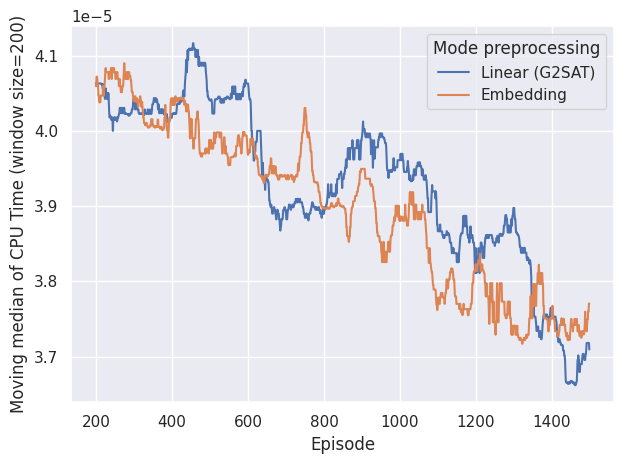

In [7]:
# Embedding
plot_metrics(
    {"Linear (G2SAT)": s1_base, "Embedding": s1_comp},
    legend_title="Mode preprocessing",
    saveto="figs/s1_embedding",
)


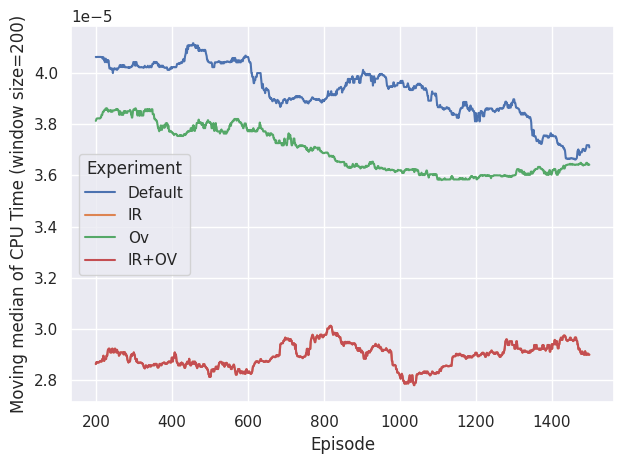

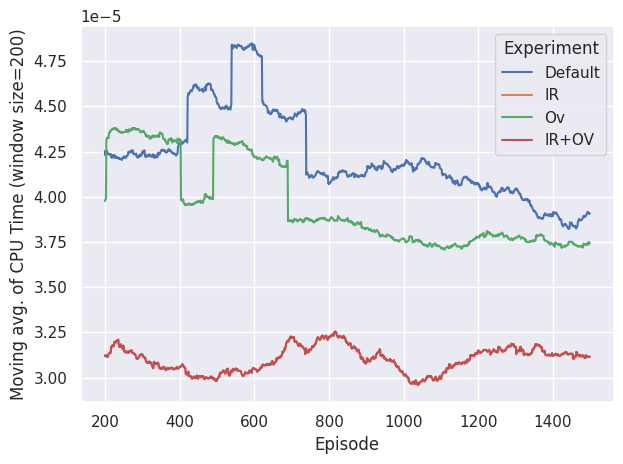

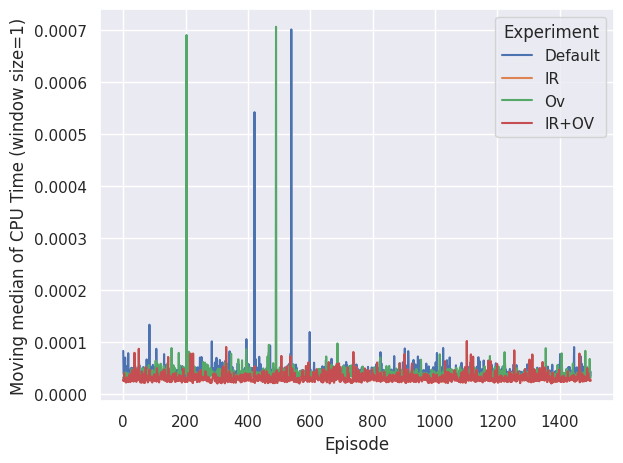

In [8]:
# IR/OV
plot_metrics(
    {"Default": s1_base, "IR": s1_int, "Ov": s1_overlaps, "IR+OV": s1_int_overlaps},
    legend_title="Experiment",
    saveto="figs/s1_ir_ov",
)
plot_metrics(
    {"Default": s1_base, "IR": s1_int, "Ov": s1_overlaps, "IR+OV": s1_int_overlaps},
    legend_title="Experiment",
    saveto="figs/s1_ir_ov_mean",
    use_median=False,
)
plot_metrics(
    {"Default": s1_base, "IR": s1_int, "Ov": s1_overlaps, "IR+OV": s1_int_overlaps},
    legend_title="Experiment",
    saveto="figs/s1_ir_ov_w1",
    window_size=1,
)


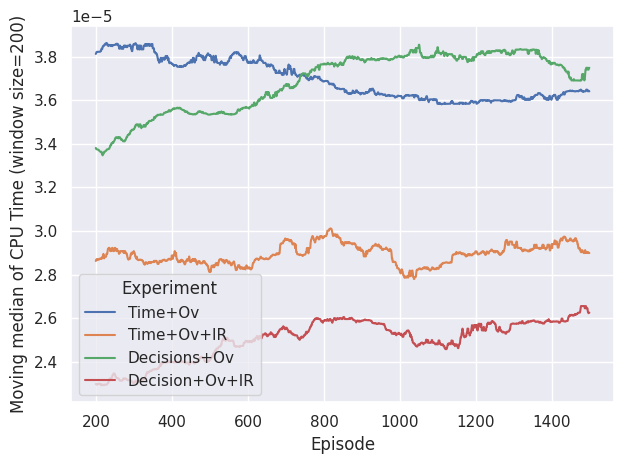

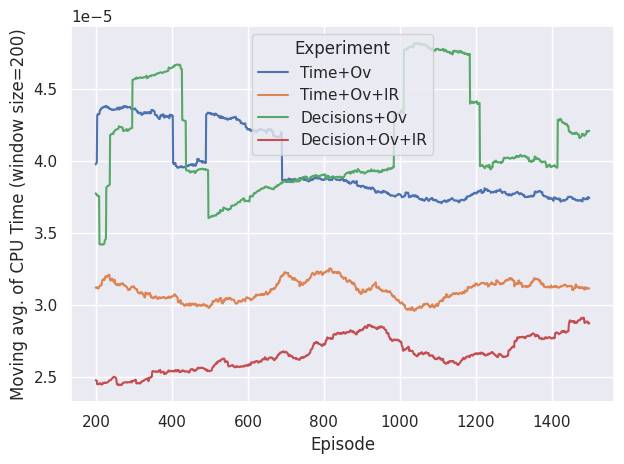

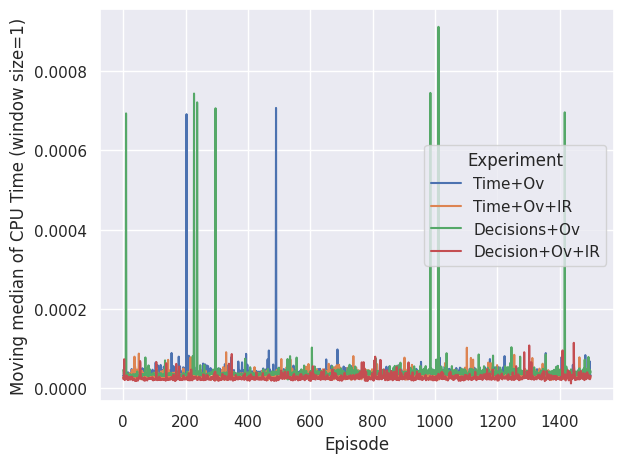

In [9]:
# IR/OV
plot_metrics(
    {
        "Time+Ov": s1_overlaps,
        "Time+Ov+IR": s1_int_overlaps,
        "Decisions+Ov": s1_overlaps_decisions,
        "Decision+Ov+IR": s1_int_overlaps_decisions,
    },
    legend_title="Experiment",
    saveto="figs/s1_decision",
)
plot_metrics(
    {
        "Time+Ov": s1_overlaps,
        "Time+Ov+IR": s1_int_overlaps,
        "Decisions+Ov": s1_overlaps_decisions,
        "Decision+Ov+IR": s1_int_overlaps_decisions,
    },
    legend_title="Experiment",
    saveto="figs/s1_decision_mean",
    use_median=False,
)
plot_metrics(
    {
        "Time+Ov": s1_overlaps,
        "Time+Ov+IR": s1_int_overlaps,
        "Decisions+Ov": s1_overlaps_decisions,
        "Decision+Ov+IR": s1_int_overlaps_decisions,
    },
    legend_title="Experiment",
    saveto="figs/s1_decision_w1",
    window_size=1,
)


(2e-05, 5.5e-05)

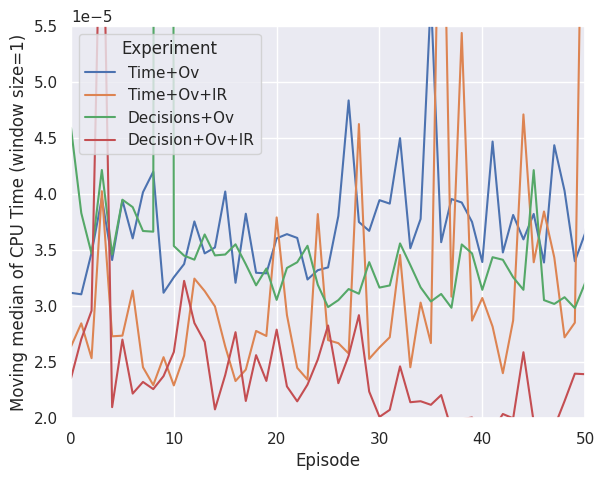

In [10]:
plot_metrics(
    {
        "Time+Ov": s1_overlaps,
        "Time+Ov+IR": s1_int_overlaps,
        "Decisions+Ov": s1_overlaps_decisions,
        "Decision+Ov+IR": s1_int_overlaps_decisions,
    },
    legend_title="Experiment",
    window_size=1,
)
plt.xlim(0, 50)
plt.ylim(2e-5, 5.5e-5)


## 2. Overlaps

In [11]:
s2_base = {}
s2_overlaps = {}

metrics = ["time_cpu", "decisions", "propagations", "conflicts", "restarts"]
for metric in metrics:
    s2_base[metric] = load_history(f"s2 (metric={metric})")
    s2_overlaps[metric] = load_history(f"s2 (metric={metric}, overlaps)")

s2_int_overlaps = {
    "decisions": load_history("s2 (metric=decisions, overlaps, int_rewards)")
}


Loaded history from s2 (metric=time_cpu)
Loaded history from s2 (metric=time_cpu, overlaps)
Loaded history from s2 (metric=decisions)
Loaded history from s2 (metric=decisions, overlaps)
Loaded history from s2 (metric=propagations)
Loaded history from s2 (metric=propagations, overlaps)
Loaded history from s2 (metric=conflicts)
Loaded history from s2 (metric=conflicts, overlaps)
Loaded history from s2 (metric=restarts)
Loaded history from s2 (metric=restarts, overlaps)
Loaded history from s2 (metric=decisions, overlaps, int_rewards)


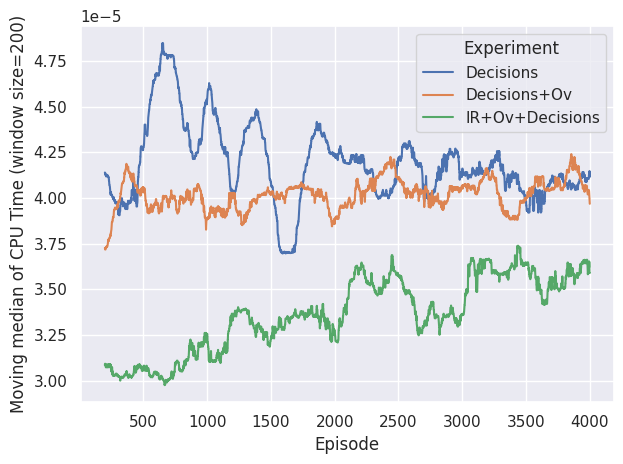

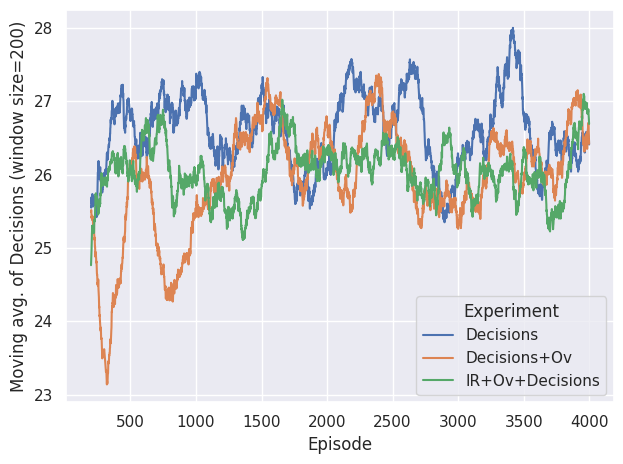

In [12]:
plot_metrics(
    {
        "Decisions": s2_base["decisions"],
        "Decisions+Ov": s2_overlaps["decisions"],
        "IR+Ov+Decisions": s2_int_overlaps["decisions"],
    },
    saveto="figs/s2_decisions_cmp",
)

plot_metrics(
    {
        "Decisions": s2_base["decisions"],
        "Decisions+Ov": s2_overlaps["decisions"],
        "IR+Ov+Decisions": s2_int_overlaps["decisions"],
    },
    metric="decisions",
    saveto="figs/s2_decisions_cmp",
)


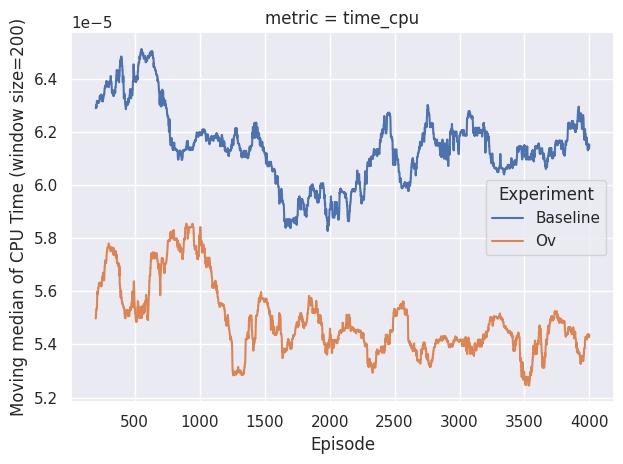

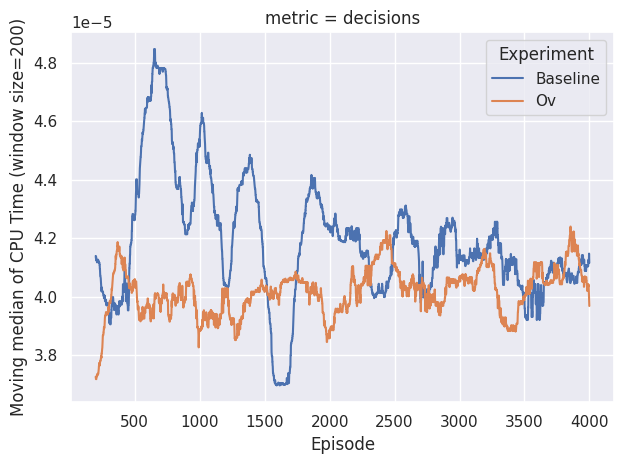

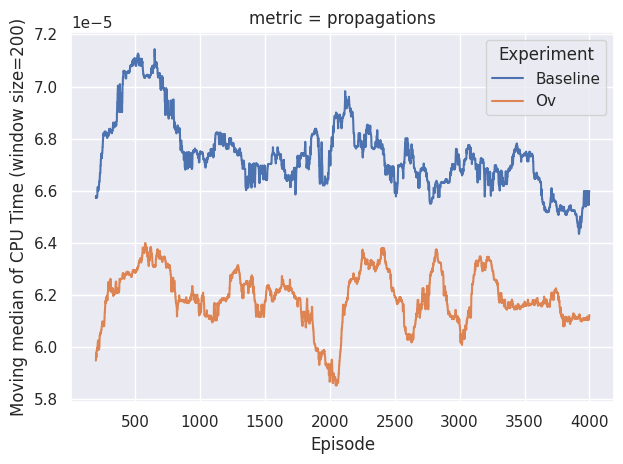

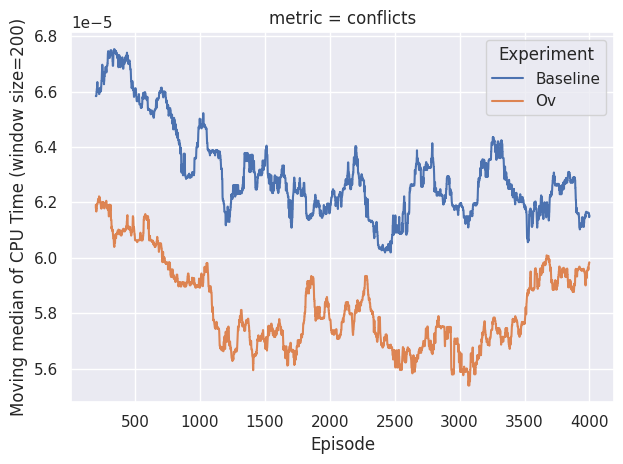

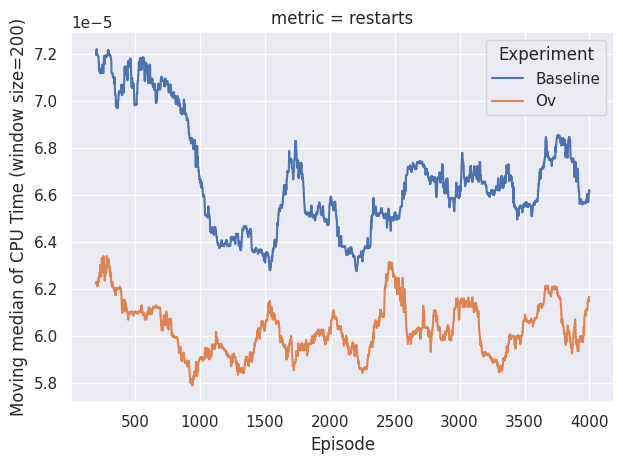

In [13]:
for metric in metrics:
    plot_metrics(
        {"Baseline": s2_base[metric], "Ov": s2_overlaps[metric]},
        legend_title="Experiment",
        saveto=f"figs/s2_metric={metric}",
        title=f"metric = {metric}",
    )


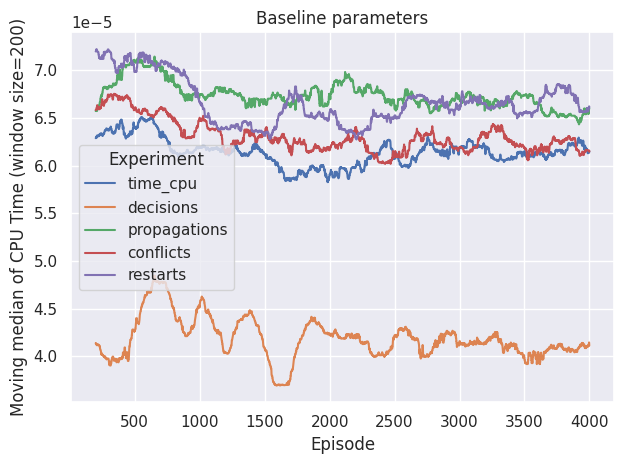

In [14]:
plot_metrics(
    s2_base,
    legend_title="Experiment",
    saveto=f"figs/s2_base_cmp",
    title=f"Baseline parameters",
)


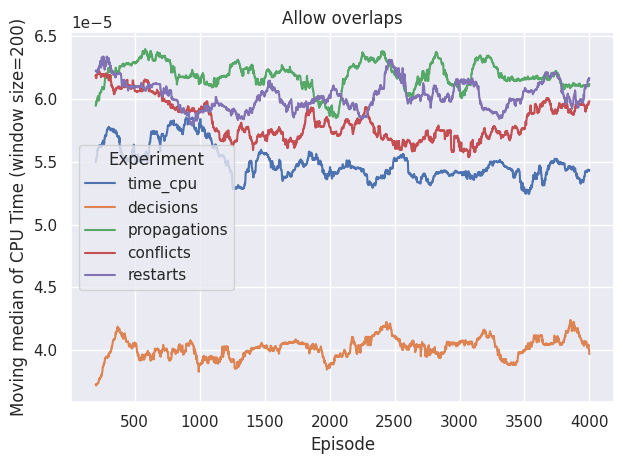

In [15]:
plot_metrics(
    s2_overlaps,
    legend_title="Experiment",
    saveto=f"figs/s2_overlaps_cmp",
    title=f"Allow overlaps",
)


#### 2.1. Correlation between metrics

In [16]:
results = pd.concat(
    [
        get_group(history.last_step, "metrics")
        for history in list(s2_int_overlaps.values())
    ]
)
results


conflicts  decisions  feasible  propagations  restarts  time_cpu
episode                                                                  
0                1         20         1            58         1  0.000024
1                0         17         1            51         1  0.000031
2                2         16         1            70         1  0.000041
3                0         20         1            51         1  0.000051
4                4         26         1           107         1  0.000039
...            ...        ...       ...           ...       ...       ...
3995             3         28         1            58         1  0.000042
3996             0         14         1            51         1  0.000022
3997             0         25         1            51         1  0.000033
3998             1         23         1            59         1  0.000034
3999             0         19         1            51         1  0.000025

[4000 rows x 6 columns]

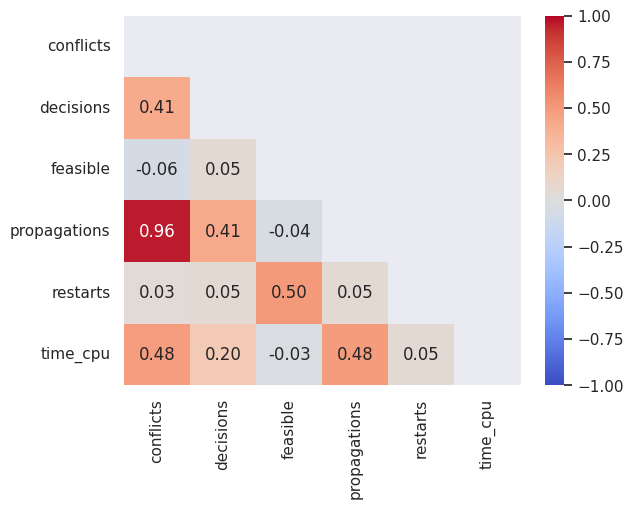

In [17]:
corr = results.corr("spearman")
corr_mask = np.triu(np.ones(len(corr)))
sns.heatmap(
    corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", mask=corr_mask
)
plt.grid()
savefig("figs/s2.1_metrics_corr.png")


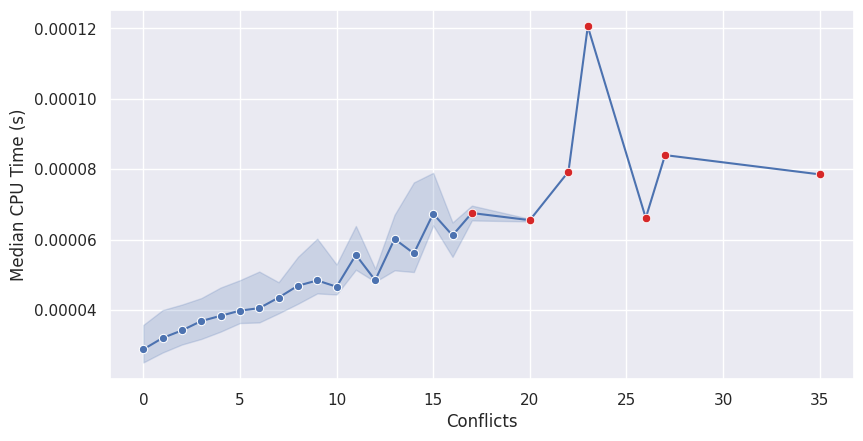

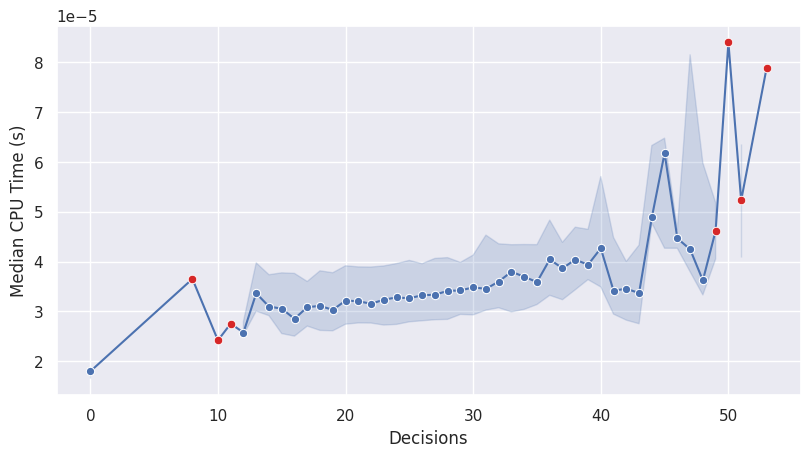

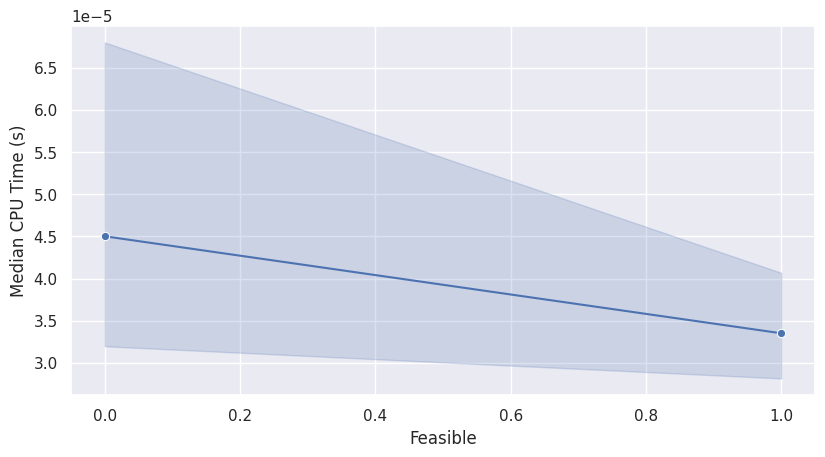

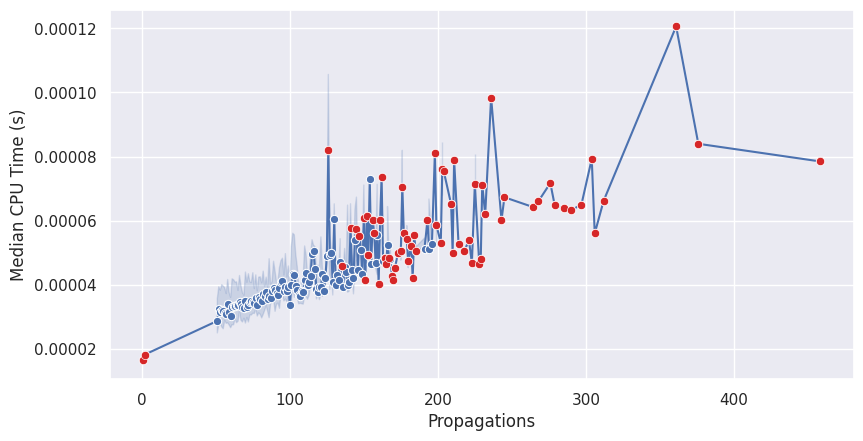

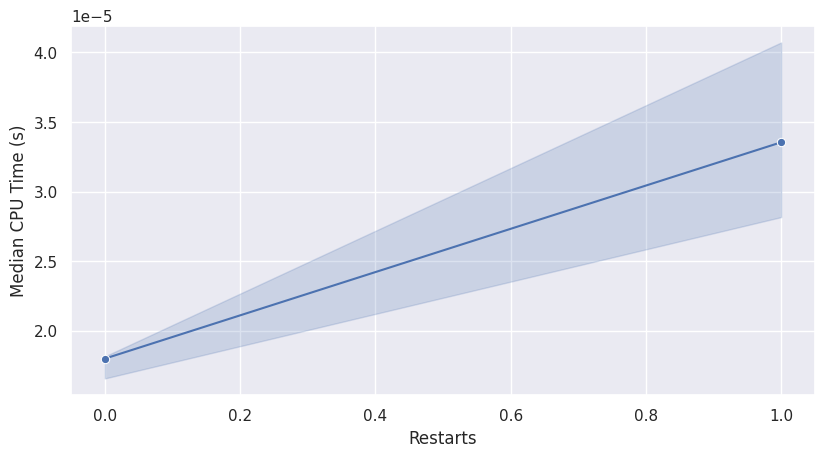

In [18]:
def find_ranges(data):
    if len(data) == 0:
        return
    data = sorted(data)
    start = end = data[0]
    for x in data[1:]:
        if x <= end + 1:
            end = x
        else:
            yield (start, end)
            start = end = x
    yield (start, end)


for metric in results.columns:
    if metric == "time_cpu":
        continue

    plt.figure(figsize=(9.6, 4.8))
    sns.lineplot(
        x=metric,
        y="time_cpu",
        estimator="median",
        errorbar=lambda x: np.percentile(x, [25, 75]),
        marker="o",
        data=results,
    )

    counts = results[metric].value_counts()
    infrequent_x = set(counts[counts < 3].index)
    to_mark = results[results[metric].isin(infrequent_x)]
    to_mark = to_mark.groupby(metric)["time_cpu"].median().reset_index()
    sns.scatterplot(x=metric, y="time_cpu", c="tab:red", data=to_mark, zorder=10000)

    plt.xlabel(metric.title())
    plt.ylabel("Median CPU Time (s)")
    savefig(f"figs/s2.1_{metric}_vs_time_median.png")


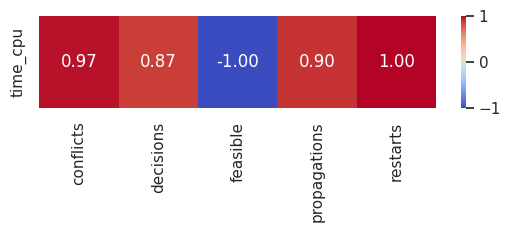

In [19]:
corr_median = pd.DataFrame(
    index=["time_cpu"], columns=results.columns, dtype=np.float64
)
corr_median.drop("time_cpu", axis=1, inplace=True)

for m1 in results.columns:
    if m1 == "time_cpu":
        continue
    corr_val = (
        results.groupby(m1)["time_cpu"]
        .median()
        .reset_index()
        .corr("spearman")
        .iloc[0, 1]
    )
    corr_median.loc["time_cpu", m1] = corr_val

plt.figure(figsize=(6.4, 1.2))
sns.heatmap(corr_median, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
savefig("figs/s2.1_metrics_corr_median.png")


#### 2.2. Analysis of intermediate rewards

## 3. Learning rate, action mode

In [20]:
s3_argmax = {}
s3_sample = {}

for lr in ("1e-3", "1e-4", "1e-5"):
    s3_argmax[lr] = load_history(f"s3 (metric=time_cpu, action_mode=argmax, lr={lr})")
    s3_sample[lr] = load_history(f"s3 (metric=time_cpu, action_mode=sample, lr={lr})")


Loaded history from s3 (metric=time_cpu, action_mode=argmax, lr=1e-3)
Loaded history from s3 (metric=time_cpu, action_mode=sample, lr=1e-3)
Loaded history from s3 (metric=time_cpu, action_mode=argmax, lr=1e-4)
Loaded history from s3 (metric=time_cpu, action_mode=sample, lr=1e-4)
Loaded history from s3 (metric=time_cpu, action_mode=argmax, lr=1e-5)
Loaded history from s3 (metric=time_cpu, action_mode=sample, lr=1e-5)


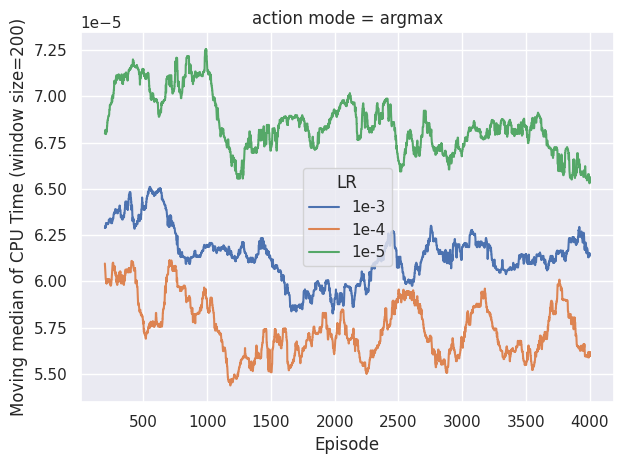

In [21]:
plot_metrics(
    s3_argmax,
    legend_title="LR",
    saveto=f"figs/s3_argmax",
    title=f"action mode = argmax",
)


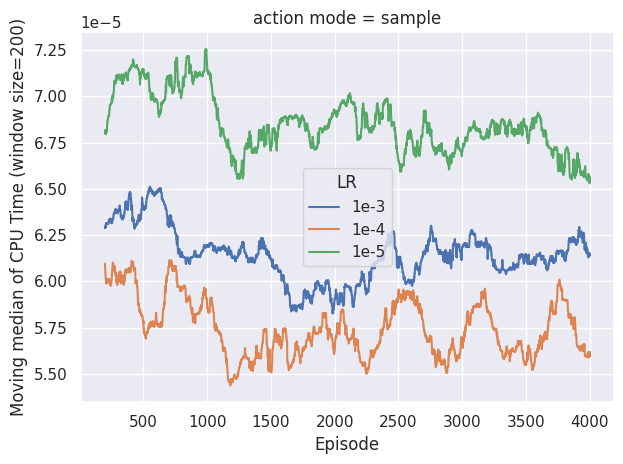

In [22]:
plot_metrics(
    s3_argmax,
    legend_title="LR",
    saveto=f"figs/s3_sample",
    title=f"action mode = sample",
)


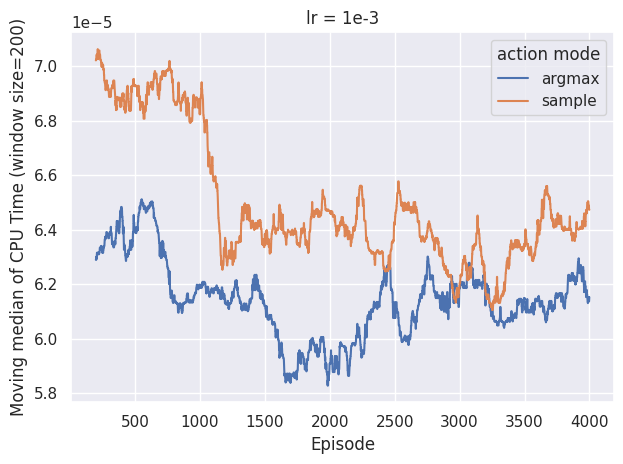

In [23]:
plot_metrics(
    {"argmax": s3_argmax["1e-3"], "sample": s3_sample["1e-3"]},
    legend_title="action mode",
    saveto=f"figs/s3_lr=1e-3",
    title=f"lr = 1e-3",
)


## 4. Intermediate rewards, learning rate

In [24]:
s4_decisions = {}
s4_decisions_ov = {}
s4_time = {}
s4_time_ov = {}

for lr in ("1e-3", "1e-4", "1e-5"):
    s4_decisions[lr] = load_history(f"s4 (metric=decisions, lr={lr}, int_rewards)")
    s4_decisions_ov[lr] = load_history(
        f"s4 (metric=decisions, lr={lr}, overlaps, int_rewards)"
    )
    s4_time[lr] = load_history(f"s4 (metric=time_cpu, lr={lr}, int_rewards)")
    s4_time_ov[lr] = load_history(
        f"s4 (metric=time_cpu, lr={lr}, overlaps, int_rewards)"
    )


Loaded history from s4 (metric=decisions, lr=1e-3, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-3, overlaps, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-3, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-3, overlaps, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-4, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-4, overlaps, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-4, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-4, overlaps, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-5, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-5, overlaps, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-5, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-5, overlaps, int_rewards)


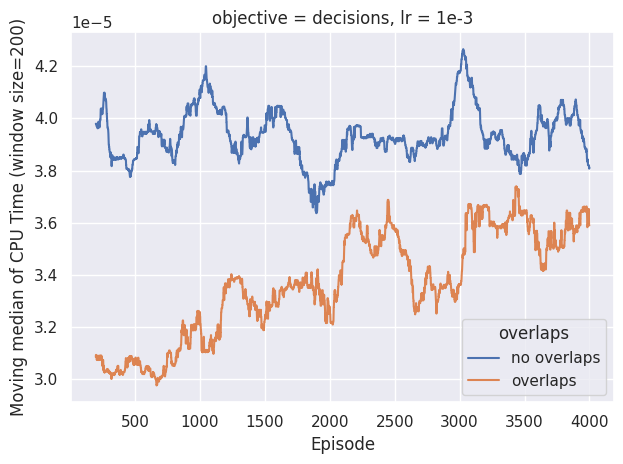

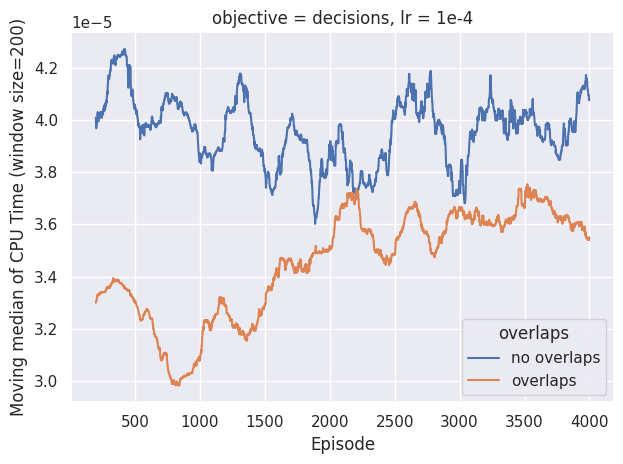

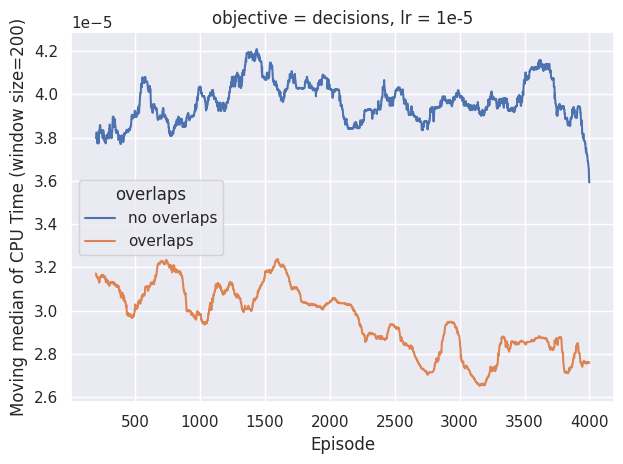

In [25]:
for lr in ("1e-3", "1e-4", "1e-5"):
    plot_metrics(
        {"no overlaps": s4_decisions[lr], "overlaps": s4_decisions_ov[lr]},
        legend_title="overlaps",
        saveto=f"figs/s4_decisions_lr{lr}",
        title=f"objective = decisions, lr = {lr}",
    )


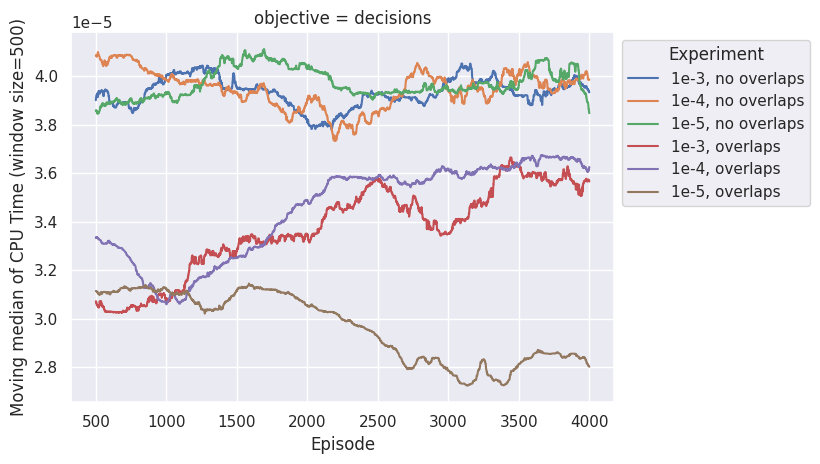

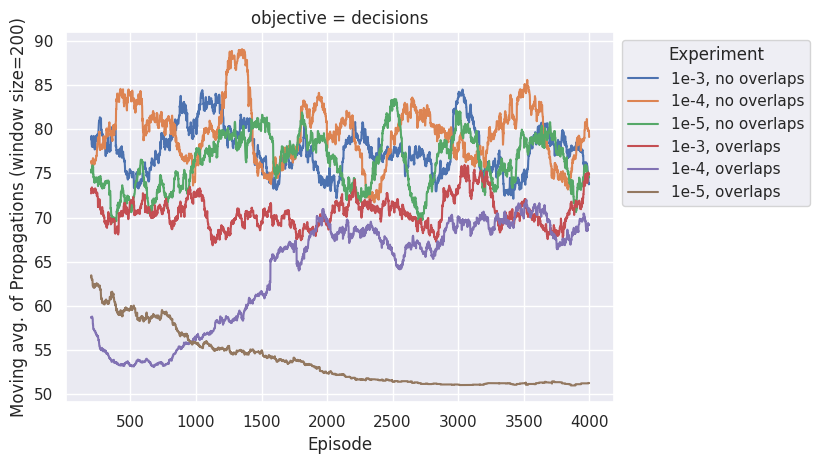

In [26]:
s4_decisions_all = {}
for k, v in s4_decisions.items():
    s4_decisions_all[k + ", no overlaps"] = v
for k, v in s4_decisions_ov.items():
    s4_decisions_all[k + ", overlaps"] = v

plot_metrics(
    s4_decisions_all,
    saveto=f"figs/s4_decisions_all_time",
    title=f"objective = decisions",
    window_size=500,
    move_legend=True,
)

plot_metrics(
    s4_decisions_all,
    saveto=f"figs/s4_decisions_all_decisions",
    title=f"objective = decisions",
    use_median=False,
    metric="propagations",
    # window_size=500,
    move_legend=True,
)


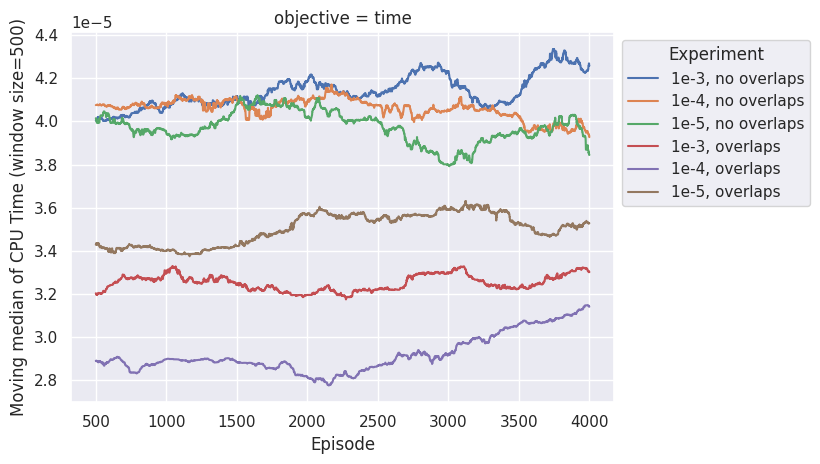

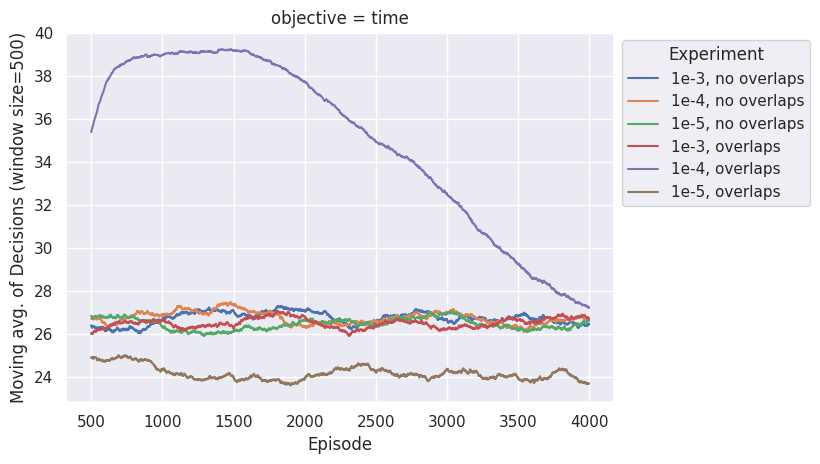

In [27]:
s4_time_all = {}
for k, v in s4_time.items():
    s4_time_all[k + ", no overlaps"] = v
for k, v in s4_time_ov.items():
    s4_time_all[k + ", overlaps"] = v

plot_metrics(
    s4_time_all,
    saveto=f"figs/s4_time_all_time",
    title=f"objective = time",
    window_size=500,
    move_legend=True,
)

plot_metrics(
    s4_time_all,
    saveto=f"figs/s4_time_all_decisions",
    title=f"objective = time",
    metric="decisions",
    window_size=500,
    move_legend=True,
)


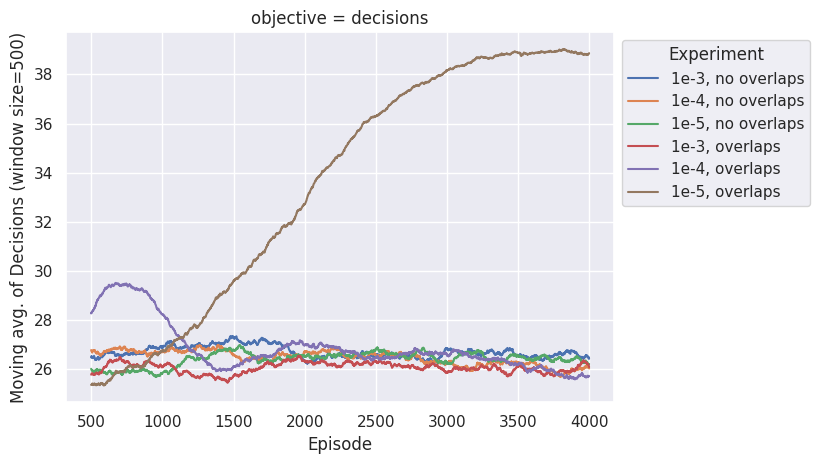

In [28]:
plot_metrics(
    s4_decisions_all,
    title=f"objective = decisions",
    metric="decisions",
    use_median=False,
    window_size=500,
    move_legend=True,
)


In [29]:
scores_decisions = pd.DataFrame()
for lr in ("1e-3", "1e-4", "1e-5"):
    for ov in ("overlaps", "no overlaps"):
        scores_decisions.loc[ov, lr] = (
            s4_decisions_all[f"{lr}, {ov}"]
            .last_step["metrics/time_cpu"]
            .iloc[-500:]
            .median()
        )

scores_time = pd.DataFrame()
for lr in ("1e-3", "1e-4", "1e-5"):
    for ov in ("overlaps", "no overlaps"):
        scores_time.loc[ov, lr] = (
            s4_time_all[f"{lr}, {ov}"]
            .last_step["metrics/time_cpu"]
            .iloc[-500:]
            .median()
        )


display(scores_decisions)
display(scores_time)


1e-3      1e-4      1e-5
overlaps     0.000036  0.000036  0.000028
no overlaps  0.000039  0.000040  0.000038

1e-3      1e-4      1e-5
overlaps     0.000033  0.000031  0.000035
no overlaps  0.000043  0.000039  0.000038

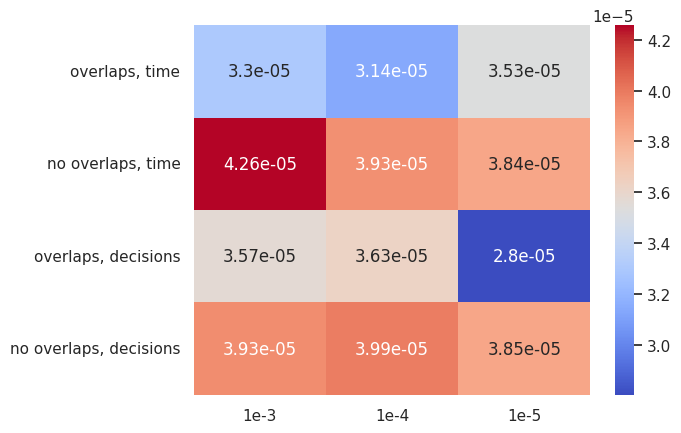

In [30]:
scores_time.index = [i + ", time" for i in scores_time.index]
scores_decisions.index = [i + ", decisions" for i in scores_decisions.index]
sns.heatmap(
    pd.concat([scores_time, scores_decisions]), cmap="coolwarm", annot=True, fmt=".3g"
)
savefig("figs/s4_matrix")


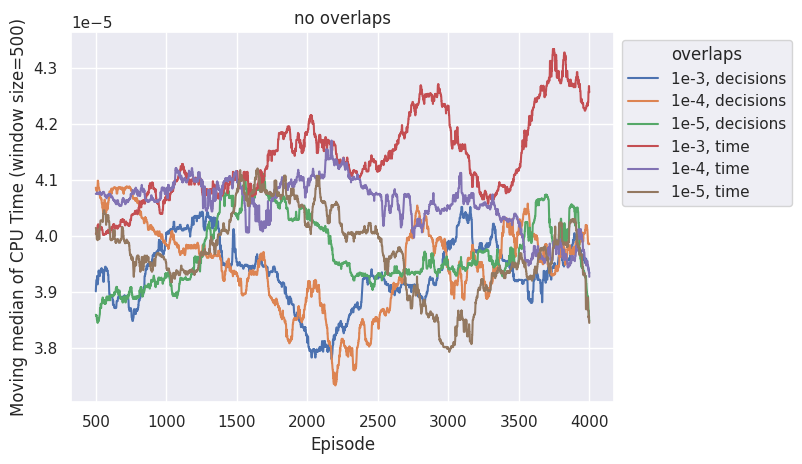

In [31]:
s4_no_ov = {}
for k, v in s4_decisions.items():
    s4_no_ov[k + ", decisions"] = v
for k, v in s4_time.items():
    s4_no_ov[k + ", time"] = v

plot_metrics(
    s4_no_ov,
    legend_title="overlaps",
    saveto=f"figs/s4_no_ov",
    title=f"no overlaps",
    window_size=500,
)
sns.move_legend(plt.gca(), loc="upper left", bbox_to_anchor=(1, 1))


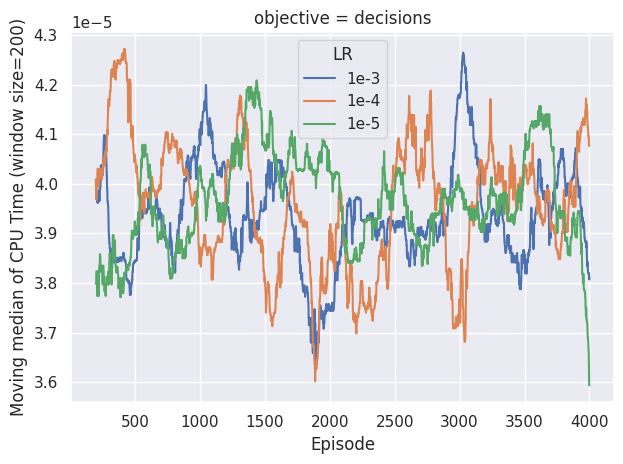

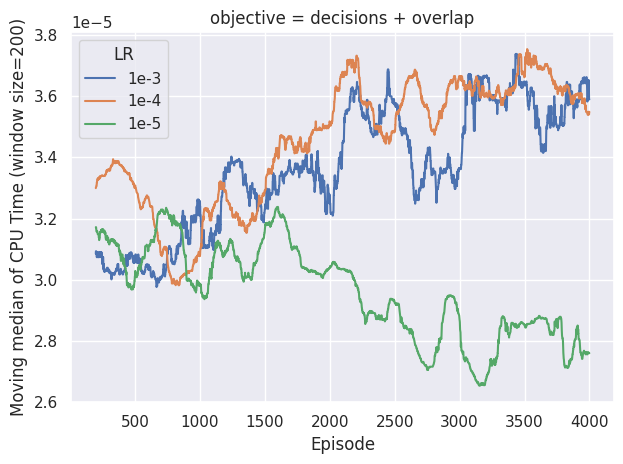

In [32]:
plot_metrics(
    s4_decisions,
    legend_title="LR",
    saveto=f"figs/s4_decisions",
    title=f"objective = decisions",
)
plot_metrics(
    s4_decisions_ov,
    legend_title="LR",
    saveto=f"figs/s4_decisions_ov",
    title=f"objective = decisions + overlap",
)


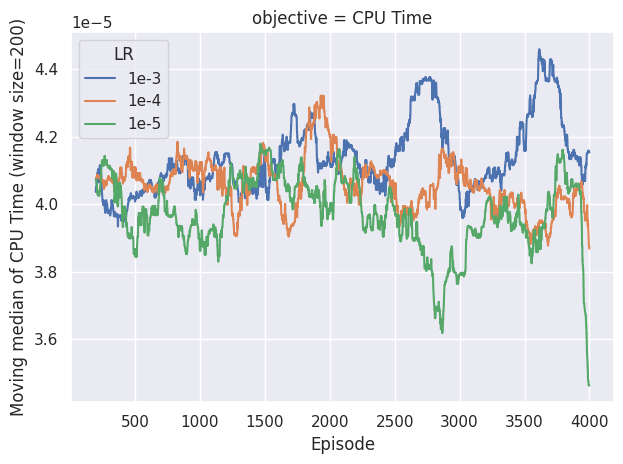

In [33]:
plot_metrics(
    s4_time,
    legend_title="LR",
    saveto=f"figs/s4_time_cpu",
    title=f"objective = CPU Time",
)


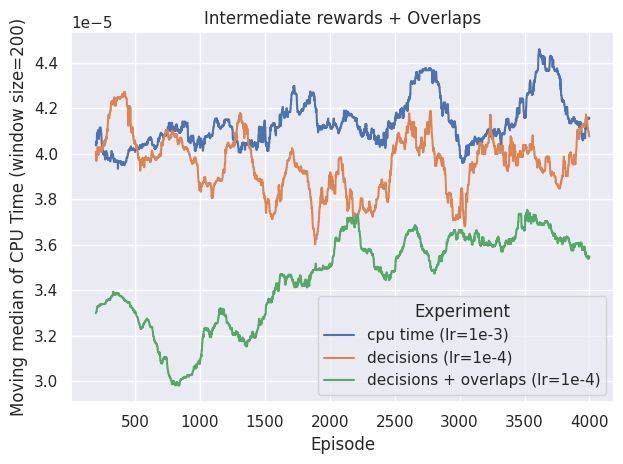

In [34]:
plot_metrics(
    {
        "cpu time (lr=1e-3)": s4_time["1e-3"],
        "decisions (lr=1e-4)": s4_decisions["1e-4"],
        "decisions + overlaps (lr=1e-4)": s4_decisions_ov["1e-4"],
    },
    saveto=f"figs/s4_best",
    title=f"Intermediate rewards + Overlaps",
)


## 5. Fixed templates

In [35]:
s5 = {}

for run in range(1, 4):
    s5[f"fixed (run {run})"] = load_history(
        f"s5 (template_mode=fixed_random, run {run})"
    )
s5[f"random"] = load_history(f"s5 (template_mode=random)")


Loaded history from s5 (template_mode=fixed_random, run 1)
Loaded history from s5 (template_mode=fixed_random, run 2)
Loaded history from s5 (template_mode=fixed_random, run 3)
Loaded history from s5 (template_mode=random)


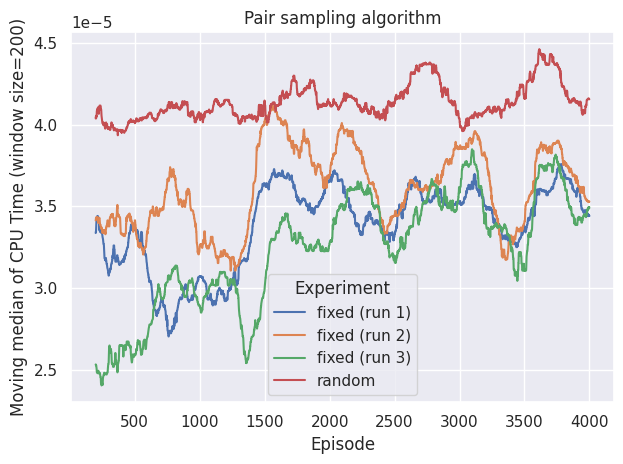

In [36]:
plot_metrics(
    s5,
    saveto=f"figs/s5",
    title=f"Pair sampling algorithm",
)


## 6. Action mode

In [37]:
s6 = {}
s6_keys = [
    "decisions, lr=1e-4",
    "decisions, lr=1e-4, overlaps",
    "time_cpu, lr=1e-3",
]

for k in s6_keys:
    s6[k + ", sample"] = load_history(
        f"s6 (metric={k}, int_rewards, action_mode=sample)"
    )
    s6[k + ", argmax"] = load_history(
        f"s6 (metric={k}, int_rewards, action_mode=argmax)"
    )


Loaded history from s6 (metric=decisions, lr=1e-4, int_rewards, action_mode=sample)
Loaded history from s6 (metric=decisions, lr=1e-4, int_rewards, action_mode=argmax)
Loaded history from s6 (metric=decisions, lr=1e-4, overlaps, int_rewards, action_mode=sample)
Loaded history from s6 (metric=decisions, lr=1e-4, overlaps, int_rewards, action_mode=argmax)
Loaded history from s6 (metric=time_cpu, lr=1e-3, int_rewards, action_mode=sample)
Loaded history from s6 (metric=time_cpu, lr=1e-3, int_rewards, action_mode=argmax)


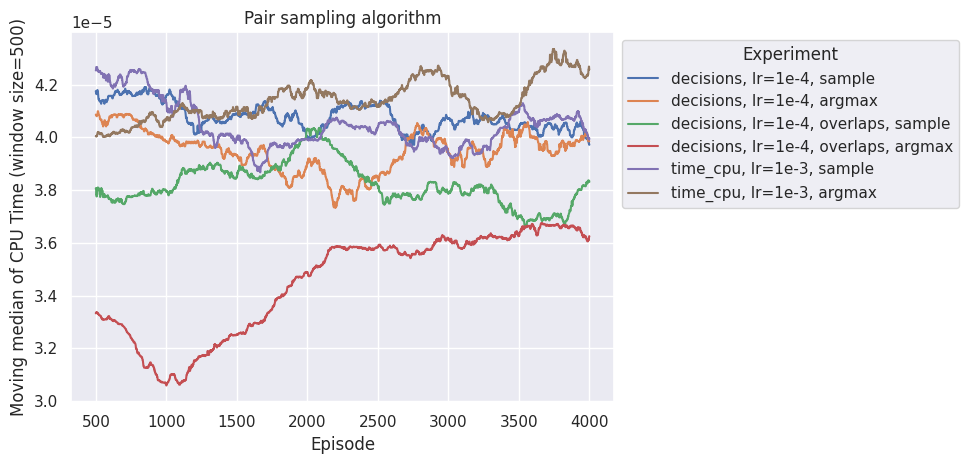

In [38]:
plot_metrics(
    s6,
    saveto=f"figs/s6",
    window_size=500,
    title=f"Pair sampling algorithm",
    move_legend=True,
)


## 7. Longer runs

In [39]:
s7 = {}
s7_keys = [
    "decisions, lr=1e-4",
    "decisions, lr=1e-4, overlaps",
    "time_cpu, lr=1e-3",
]

for k in s7_keys:
    s7[k] = load_history(f"s7 (metric={k}, int_rewards)")


Loaded history from s7 (metric=decisions, lr=1e-4, int_rewards)
Loaded history from s7 (metric=decisions, lr=1e-4, overlaps, int_rewards)
Loaded history from s7 (metric=time_cpu, lr=1e-3, int_rewards)


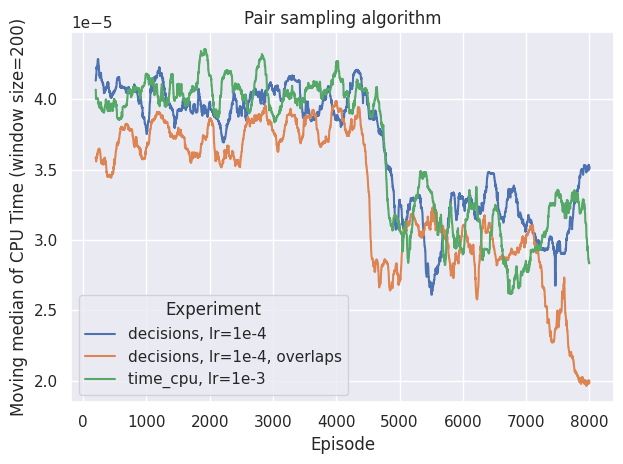

In [40]:
plot_metrics(
    s7,
    saveto=f"figs/s7",
    title=f"Pair sampling algorithm",
)


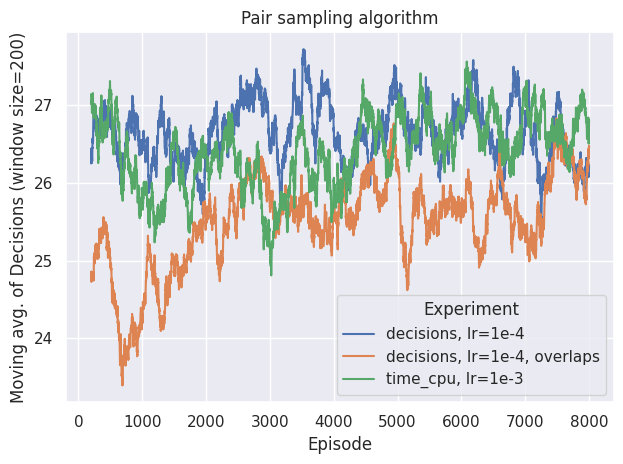

In [41]:
plot_metrics(
    s7,
    metric="decisions",
    use_median=False,
    title=f"Pair sampling algorithm",
)


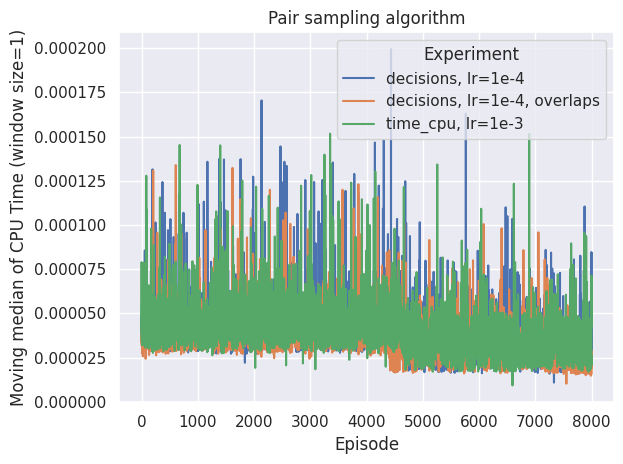

In [42]:
plot_metrics(
    s7,
    window_size=1,
    title=f"Pair sampling algorithm",
)


## 8. Fixed seed

In [22]:
s8_int = {}
s8_noint = {}
s8 = {}

for lr in ("1e-3", "1e-4", "1e-5"):
    s8[f"lr={lr}"] = load_history(f"s8 (lr={lr})")
    s8[f"lr={lr}, int_rewards"] = load_history(f"s8 (lr={lr}, int_rewards)")
    s8[f"lr={lr}, overlaps"] = load_history(f"s8 (lr={lr}, overlaps)")
    s8[f"lr={lr}, overlaps, int_rewards"] = load_history(
        f"s8 (lr={lr}, overlaps, int_rewards)"
    )

    s8_noint[f"lr={lr}"] = s8[f"lr={lr}"]
    s8_noint[f"lr={lr}, overlaps"] = s8[f"lr={lr}, overlaps"]
    s8_int[f"lr={lr}"] = s8[f"lr={lr}, int_rewards"]
    s8_int[f"lr={lr}, overlaps"] = s8[f"lr={lr}, overlaps, int_rewards"]


Loaded history from s8 (lr=1e-3)
Loaded history from s8 (lr=1e-3, int_rewards)
Loaded history from s8 (lr=1e-3, overlaps)
Loaded history from s8 (lr=1e-3, overlaps, int_rewards)
Loaded history from s8 (lr=1e-4)
Loaded history from s8 (lr=1e-4, int_rewards)
Loaded history from s8 (lr=1e-4, overlaps)
Loaded history from s8 (lr=1e-4, overlaps, int_rewards)
Loaded history from s8 (lr=1e-5)
Loaded history from s8 (lr=1e-5, int_rewards)
Loaded history from s8 (lr=1e-5, overlaps)
Loaded history from s8 (lr=1e-5, overlaps, int_rewards)


(60.0, 85.0)

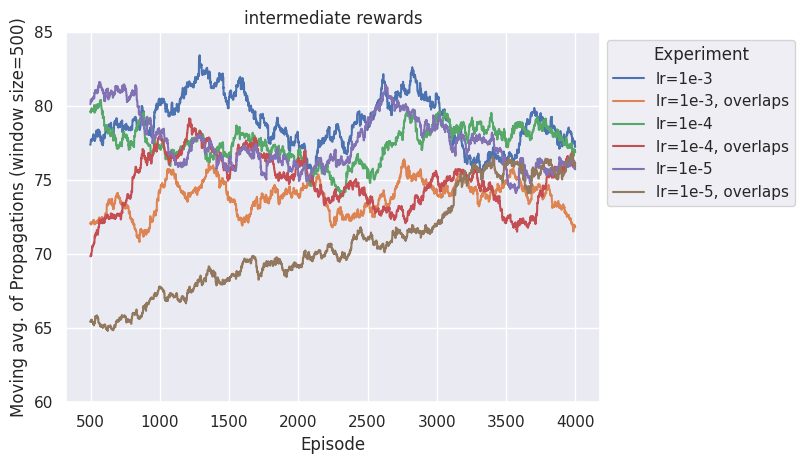

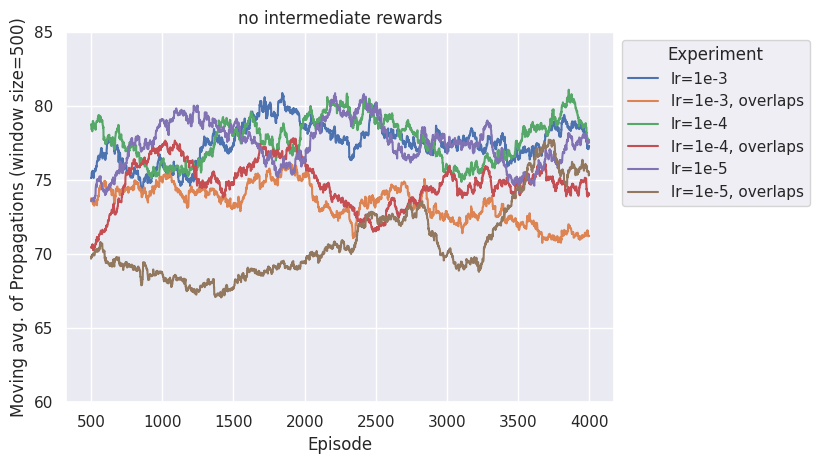

In [39]:
plot_metrics(
    s8_int,
    move_legend=True,
    window_size=500,
    metric="propagations",
    title="intermediate rewards",
)
plt.ylim(60, 85)

plot_metrics(
    s8_noint,
    move_legend=True,
    window_size=500,
    metric="propagations",
    title="no intermediate rewards",
)
plt.ylim(60, 85)


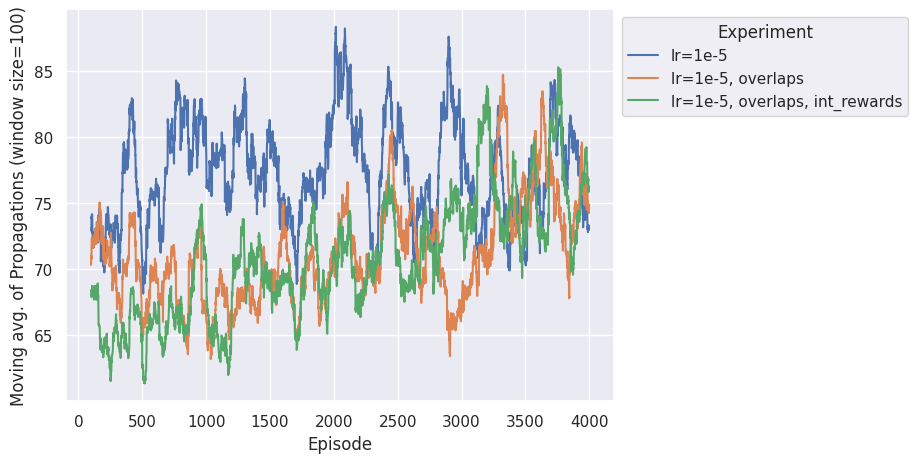

In [108]:
keys = [
    "lr=1e-5",
    "lr=1e-5, overlaps",
    "lr=1e-5, overlaps, int_rewards",
]

plot_metrics(
    {k: s8[k] for k in keys},
    move_legend=True,
    window_size=100,
    metric="propagations",
)

# plt.xlim(0, 10)
# plt.ylim(20, 80)

## 9. Longer experiments + time

In [71]:
s9_propagations = {
    "defaults": load_history(
        "s9 (metric=propagations)",
    ),
    "overlaps": load_history(
        "s9 (metric=propagations, overlaps)",
    ),
    "overlaps, int_rewards": load_history(
        "s9 (metric=propagations, overlaps, int_rewards)",
    ),
}
s9_time = {
    "overlaps, reps=2, agg=min": load_history(
        "s9 (metric=time_cpu, reps=2, agg=min, overlaps)"
    ),
    "overlaps, int_rewards, reps=2, agg=min": load_history(
        "s9 (metric=time_cpu, reps=2, agg=min, overlaps, int_rewards)"
    ),
    "overlaps, reps=3, agg=median": load_history(
        "s9 (metric=time_cpu, reps=3, agg=median, overlaps)"
    ),
    "overlaps, int_rewards, reps=3, agg=median": load_history(
        "s9 (metric=time_cpu, reps=3, agg=median, overlaps, int_rewards)"
    ),
}

s9 = {}
for k, v in s9_propagations.items():
    s9["metric=propagations, " + k] = v
for k, v in s9_time.items():
    s9["metric=time_cpu, " + k] = v


/tmp/ipykernel_85900/1513131974.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_85900/1513131974.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_85900/1513131974.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


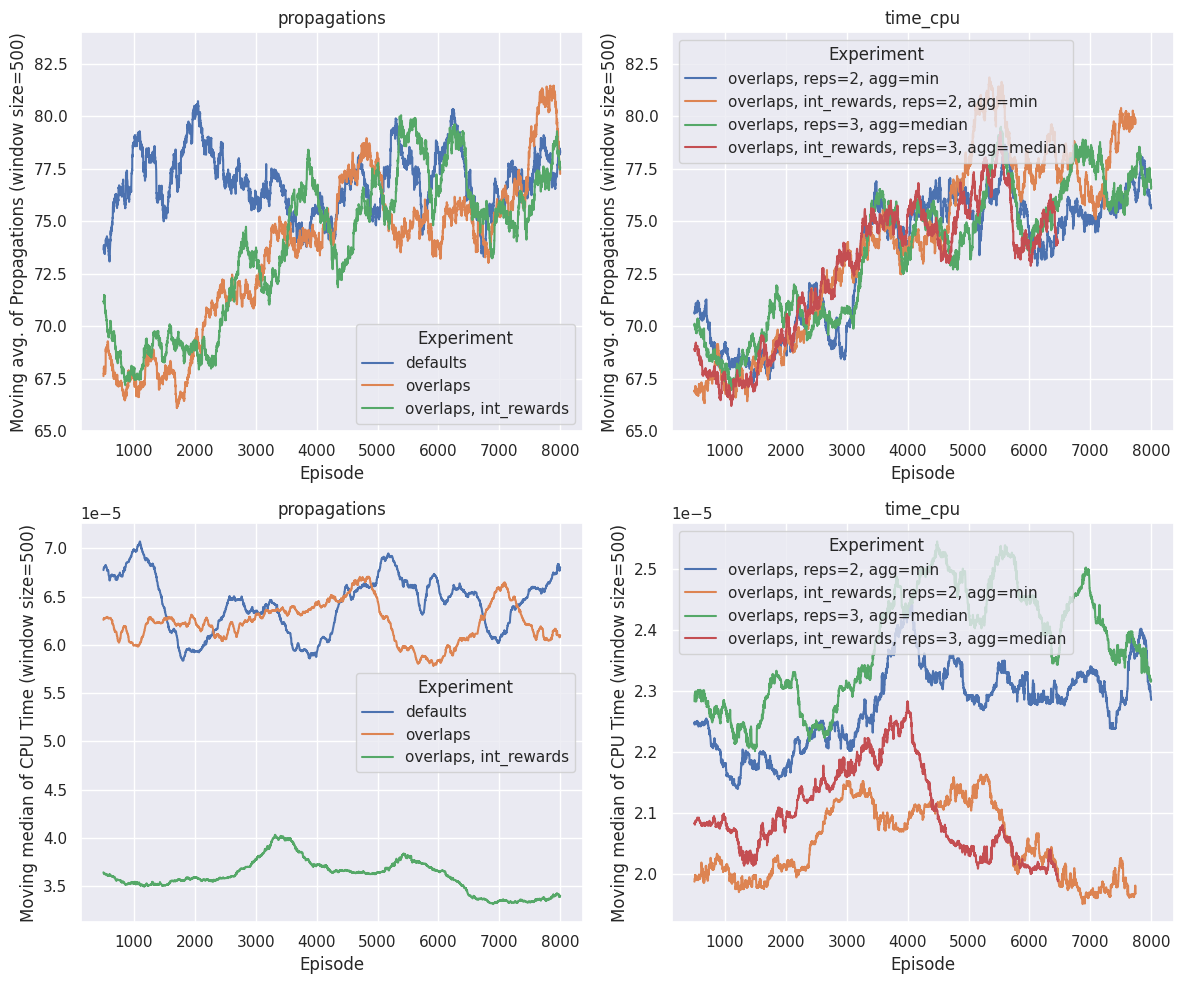

In [109]:
plt.figure(figsize=(12, 10))
plt.subplot(221)
plot_metrics(
    s9_propagations,
    # move_legend=True,
    window_size=500,
    metric="propagations",
    title="propagations",
    new_figure=False,
)
plt.ylim(65, 84)

plt.subplot(222)
plot_metrics(
    s9_time,
    # move_legend=True,
    window_size=500,
    metric="propagations",
    title="time_cpu",
    new_figure=False,
)
plt.ylim(65, 84)

plt.subplot(223)
plot_metrics(
    s9_propagations,
    # move_legend=True,
    window_size=500,
    metric="time_cpu",
    title="propagations",
    new_figure=False,
)
# plt.ylim(3e-5, 7.5e-5)

plt.subplot(224)
plot_metrics(
    s9_time,
    # move_legend=True,
    window_size=500,
    metric="time_cpu",
    title="time_cpu",
    new_figure=False,
)
# plt.ylim(1.9e-5, 7.5e-5)


/tmp/ipykernel_85900/1513131974.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(0.0, 0.0004)

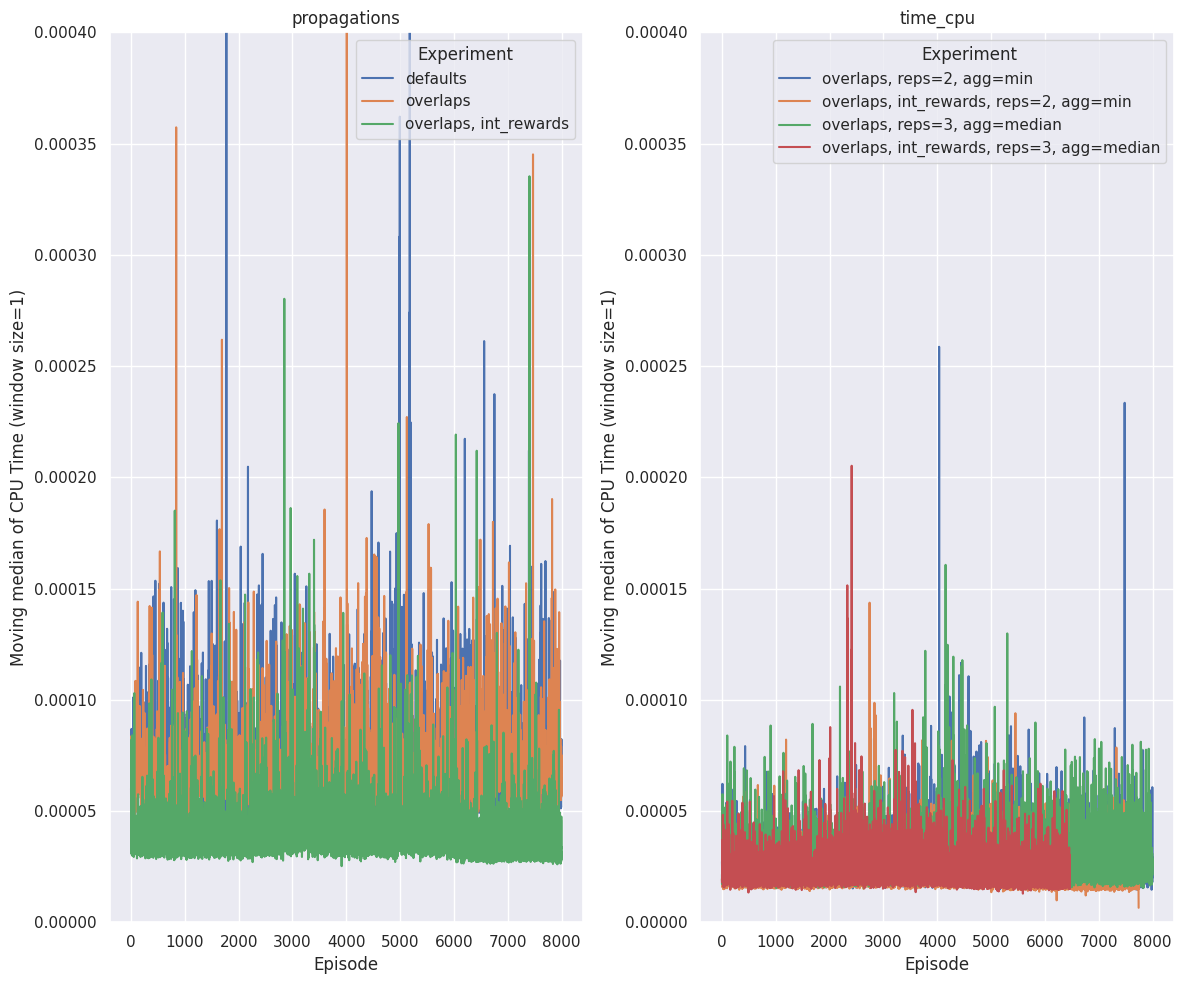

In [104]:
plt.figure(figsize=(12, 10))

plt.subplot(121)
plot_metrics(
    s9_propagations,
    # move_legend=True,
    window_size=1,
    metric="time_cpu",
    title="propagations",
    new_figure=False,
)
plt.ylim(0, 0.0004)

plt.subplot(122)
plot_metrics(
    s9_time,
    # move_legend=True,
    window_size=1,
    metric="time_cpu",
    title="time_cpu",
    new_figure=False,
)
plt.ylim(0, 0.0004)

## Others

In [47]:
s9_main = {
    "baseline": load_history(f"s8 (BROKEN, seed=0, templates=0)"),
    "overlaps": load_history(
        f"s8 (BROKEN, overlaps, int_rewards, seed=0, templates=0)"
    ),
    "intermediate rewards": load_history(
        f"s8 (BROKEN, int_rewards, seed=0, templates=0)"
    ),
    "intermediate rewards + overlaps": load_history(
        f"s8 (BROKEN, overlaps, int_rewards, seed=0, templates=0)"
    ),
}
s9_seed = {}
s9_template = {}
s9_both = {}

for seed in (0, 1, 2):
    s9_seed[f"seed={seed}, templates=0"] = load_history(
        f"s8 (BROKEN, overlaps, int_rewards, seed={seed}, templates=0)"
    )
    s9_template[f"seed=0, templates={seed}"] = load_history(
        f"s8 (BROKEN, overlaps, int_rewards, seed=0, templates={seed})"
    )
    s9_both[f"seed={seed}, templates={seed}"] = load_history(
        f"s8 (BROKEN, overlaps, int_rewards, seed={seed}, templates={seed})"
    )


Loaded history from s8 (BROKEN, seed=0, templates=0)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=0, templates=0)
Loaded history from s8 (BROKEN, int_rewards, seed=0, templates=0)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=0, templates=0)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=0, templates=0)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=0, templates=0)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=0, templates=0)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=1, templates=0)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=0, templates=1)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=1, templates=1)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=2, templates=0)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=0, templates=2)
Loaded history from s8 (BROKEN, overlaps, int_rewards, seed=2, templates=2)


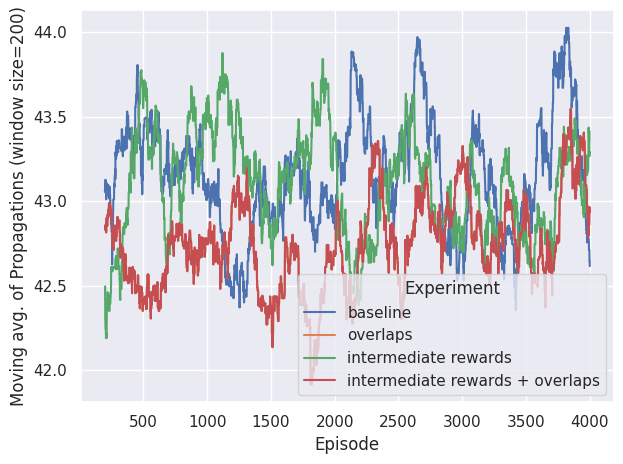

In [48]:
plot_metrics(s9_main, use_median=False, metric="propagations")


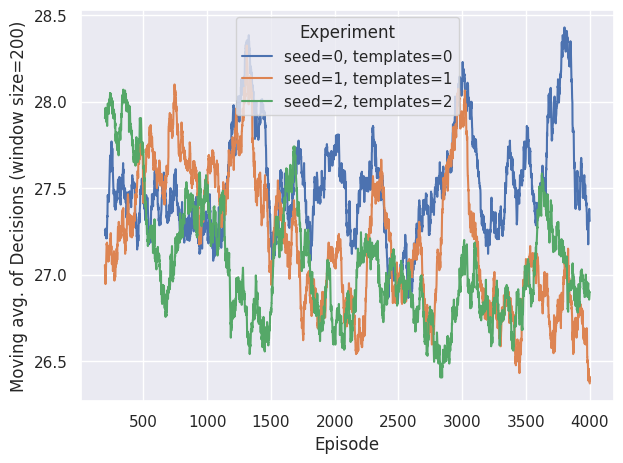

In [49]:
plot_metrics(s9_both, use_median=False, metric="decisions")
